In [1]:
!git clone https://github.com/MrGrayTheET/futures_ml

Cloning into 'futures_ml'...
remote: Enumerating objects: 39, done.
remote: Counting objects: 100% (39/39), done.
remote: Compressing objects: 100% (38/38), done.
remote: Total 39 (delta 17), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (39/39), 21.12 KiB | 10.56 MiB/s, done.
Resolving deltas: 100% (17/17), done.


In [16]:
from futures_ml.utils import clean_arrays, sierra_charts as sc
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim


In [ ]:
from futures_ml import torch_dl


In [17]:
cl_data = sc().format_sierra(pd.read_csv('/CL22-24.csv')).resample('30min').apply(sc().resample_logic)

In [28]:
import pandas_ta as ta
from futures_ml import feature_builder as fb

pre_mod = fb.model_prep(cl_data, ohlc=['Open', 'High', 'Low', 'Last'])
pre_mod.add_SMA(20)
pre_mod.bid_ask_vol_features()
pre_mod.supply_demand_zone(normalize=False, drop_non_normals=False)
pre_mod.wavelet_transform('db2', 3)



(array([87.57334129, 87.55151978, 87.66198971, ..., 82.17786788,
        82.25561897, 82.34539499]),
 [array([33838.82685555, 14077.37079349,  9538.63294914,  7512.98485049,
          6763.56016869,  7208.12792251,  7154.50809519,  7457.46316373]),
  array([    0.        , -1364.36349243,  -143.14119747,    15.4283952 ,
           454.78400779,  -168.67010826,    13.23555269,     0.        ]),
  array([   0.        , -325.58410759,  418.30379544, -144.33467141,
           98.30129394,   46.27905127,   89.15942544,  -99.24231232,
          294.34664388, -164.41990584,  244.80380329,    2.34634106,
           -0.        ]),
  array([   0.        , -417.43914097,   71.73249991, -105.03427692,
          138.02402973, -108.05751718, -108.36447437,  116.85959464,
         -120.32747077,   66.97134324,   29.44822906,  192.19721511,
           -4.22351332,  -83.75065252, -101.10832924,   57.25189341,
          -18.86966743,  -40.73597557,   -2.98457558,    0.45423773,
           -0.731436  ,  

In [32]:
features = ['Open', 'High', 'Low', 'Last', 'Volume', 'BidVolume', 'AskVolume',
       'NumberOfTrades', '20SMA','avg_size', 'Delta', 'D1', 'D2']

In [33]:
[train_x, train_y], [test_x, test_y], y_scaler = clean_arrays(pre_mod.data, feats=features, target_col='Last',
                                                              sequence=True, periods_in=130, periods_out=24, scale_y=True, minmax_settings=(0,2),
                                                              to_tensor=True, return_y_scaler=True)

In [39]:
train_y = torch.reshape(train_y, (train_y.shape[0], train_y.shape[1]))
test_y = torch.reshape(test_y, (test_y.shape[0], test_y.shape[1]))

lr = 0.001
lstm = torch_dl.lstm(36, train_x.shape[2], 24, 1)
loss = nn.MSELoss()
optimizer = optim.Adam(lstm.parameters(), lr)

torch_dl.training_loop(n_epochs=250, lstm=lstm, optimizer=optimizer, loss_func=loss, X_train=train_x, y_train=train_y, X_test=test_x, y_test=test_y)

Epoch: 0, train_loss: 0.6041945815086365 test_loss: 0.22531837224960327
Epoch: 100, train_loss: 0.0055432068184018135 test_loss: 0.0033428717870265245
Epoch: 200, train_loss: 0.002764220116659999 test_loss: 0.000846921990159899


TypeError: cannot unpack non-iterable NoneType object

In [42]:
train_predict = lstm(train_x)
test_predict = lstm(test_x)

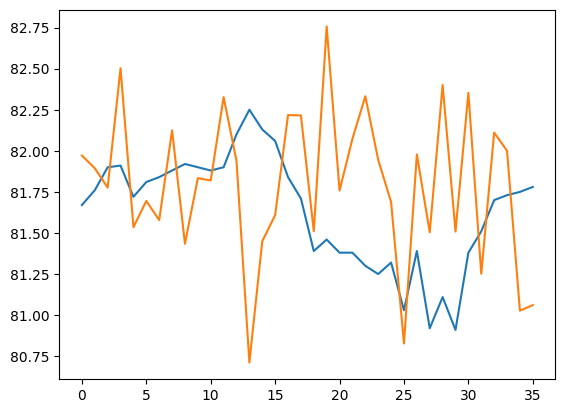

In [43]:
torch_dl.plot_final_prediction(test_x, test_y, y_scaler, lstm)

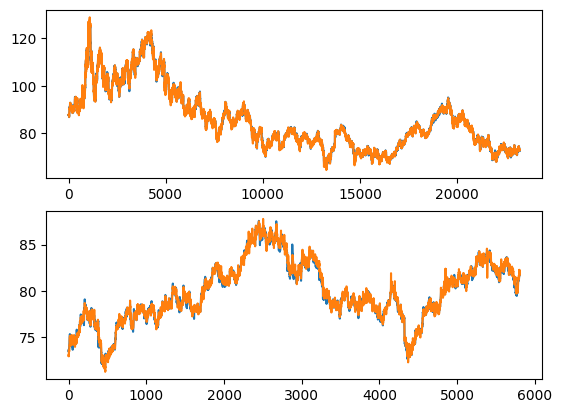

{'eval_datetime': [Timestamp('2024-07-24 00:16:43.405954')], 'r2_score': [0.9341901623886242], 'mse': [0.0006517989], 'rmse': [0.024759375], 'rmse/sd': [0.24550459], 'mape': [4.364519938826561e-08], 'sorted_features': False, 'features': [['Open', 'High', 'Low', 'Last', 'Volume', 'BidVolume', 'AskVolume', 'NumberOfTrades', '20SMA', 'avg_size', 'Delta', 'D1', 'S1']]}


{'eval_datetime': [Timestamp('2024-07-24 00:16:43.405954')],
 'r2_score': [0.9341901623886242],
 'mse': [0.0006517989],
 'rmse': [0.024759375],
 'rmse/sd': [0.24550459],
 'mape': [4.364519938826561e-08],
 'sorted_features': False,
 'features': [['Open',
   'High',
   'Low',
   'Last',
   'Volume',
   'BidVolume',
   'AskVolume',
   'NumberOfTrades',
   '20SMA',
   'avg_size',
   'Delta',
   'D1',
   'S1']]}

In [45]:
from futures_ml.utils import evaluate_model, plot_predictions
plot_predictions(train_predict, test_predict, train_y, test_y, y_scaler)
evaluate_model(test_predict.data.numpy(), test_y.data.numpy(), features)

In [50]:
torch.save(lstm, '/crude_lstm')
